In [1]:
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

from positivitree.tree_vis import visualize_leaves_static, visualize_leaves_interactive
from positivitree import PositiviTree
import pandas as pd
import sys, os
sys.path.append('../')
sys.path.append('./overlap-code')

from utils import get_data

import time

In [2]:
np.random.seed(123)

In [2]:
df = pd.read_csv('../data/synth_2d_df.csv')
a = df['t']
X = df[['x1', 'x2']]

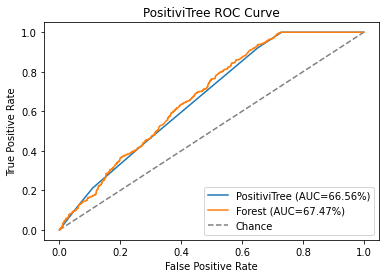

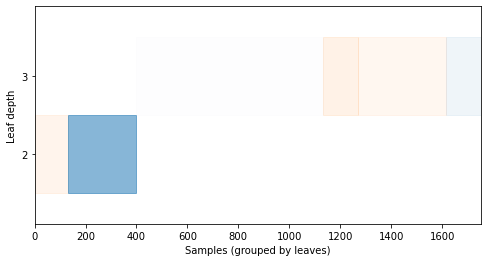

End.


In [3]:
ptree = PositiviTree(X, a,
                     violation_cutoff=0.1, consistency_cutoff=0.99,
                     n_consistency_tests=200, relative_violations=False,
                     # search_kws={"n_iter": 200},
                     dtc_kws={"criterion": "entropy"},
                     rfc_kws={"max_features": "auto"}
                     )

flagged_leaves = ptree._flag_out_leaves()
violating_samples = ptree._get_violating_samples_mask()
counts = ptree._count_violating_samples_in_forest(normalize=True)
tree_json_full = ptree.export_tree()
scores = ptree.evaluate_fit(plot_roc=True)

ax = visualize_leaves_static(ptree)
visualization_data = visualize_leaves_interactive(ptree, output_path='results/positivitree_viz_synth_2d.html')

print("End.")

In [4]:
leaves = ptree.export_leaves(extract_rules_kws={"clause_joiner": None})
violating_leaves = [leaf for leaf in leaves if leaf['is_violating']]

q_set = set()
for leaf in violating_leaves:
    for q in leaf['query']:
        print(q)
        q_set.add(q.feature_name)

print(len(q_set))
print(q_set)

(x2>0.011525199748575687)
(x1>-0.00043236499186605215)
2
{'x1', 'x2'}


In [5]:
encoding = pd.read_csv('../data/encoding.csv')
def get_lbl(var):
    return encoding[encoding['var_name'] == var].iloc[0].label

In [9]:
data = pd.read_csv('../data/fp_injectables_data.csv')

remove = ['v213', 'v210']

for c in data.columns[:-2]:
    if 'definition' in get_lbl(c):
        remove.append(c)
        
X_ = data[data.columns[:-2]]
X = X_.drop(columns=remove)
full_c = X.corr().abs()
c = X.corr().abs()
c = c * np.tri(c.shape[0], c.shape[1], -1)
c = c.transpose()

thresholds = [.99, .98, .97, .96, .95, .94, .93, .92, .91, .90]
corr_cols_len = []
for t in thresholds:
    corr_cols = [col for col in c.columns if any(c[col] > t) ]
    corr_cols_len.append(len(corr_cols))

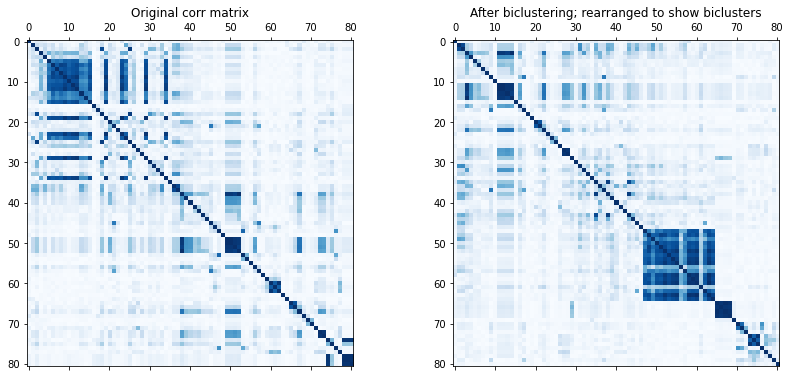

In [10]:
k = 4
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(14, 6)

axs[0].matshow(full_c, cmap=plt.cm.Blues)
axs[0].set_title("Original corr matrix")

model = SpectralCoclustering(n_clusters=k, random_state=int(time.time())) #1607085521
model.fit(full_c)

fit_data = full_c.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

axs[1].matshow(fit_data, cmap=plt.cm.Blues)
axs[1].set_title("After biclustering; rearranged to show biclusters")

plt.show()

In [11]:
model

SpectralCoclustering(n_clusters=4, random_state=1607088751)

In [178]:
fig.savefig('corr_matrix_clustering.pdf')

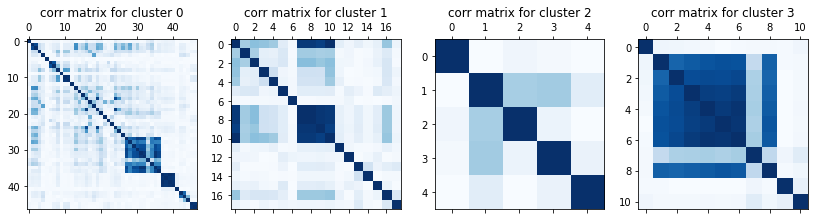

In [12]:
fig, axs = plt.subplots(1, k)
fig.set_size_inches(14, 6)
highly_corrs = []
for i in range(k):
    cluster_label = i
    cluster = fit_data.iloc[np.where(model.row_labels_ == cluster_label)[0]].iloc[:, np.where(model.column_labels_ == cluster_label)[0]]

    axs[i].matshow(cluster, cmap=plt.cm.Blues)
    axs[i].set_title("corr matrix for cluster {}".format(i))
    
    highly_corr = [c for c in cluster.columns if any((cluster[c] > .90) & (cluster[c] < 1.0))]
    highly_corrs.append(highly_corr)
    
plt.show()

In [14]:
print(highly_corrs)

[['v190', 'v191', 'v602', 'v605', 'v133', 'v149', 'v106', 'v119', 'v121', 'v122', 'v125', 'v135', 'v129', 'v627', 'v613', 'v628', 'v629', 'v364', 'v313'], ['v201', 'v218', 'v219', 'v220', 'v224'], [], ['v123', 'v124', 'v139', 'v161', 'v153']]


In [15]:
cols = highly_corrs[0]

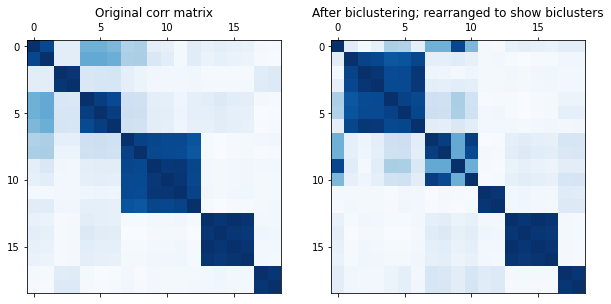

In [17]:
full_c = full_c[cols].loc[cols]

k = 4
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 6)

axs[0].matshow(full_c, cmap=plt.cm.Blues)
axs[0].set_title("Original corr matrix")

model = SpectralCoclustering(n_clusters=k, random_state=int(time.time()))
model.fit(full_c)

fit_data = full_c.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

axs[1].matshow(fit_data, cmap=plt.cm.Blues)
axs[1].set_title("After biclustering; rearranged to show biclusters")

plt.show()

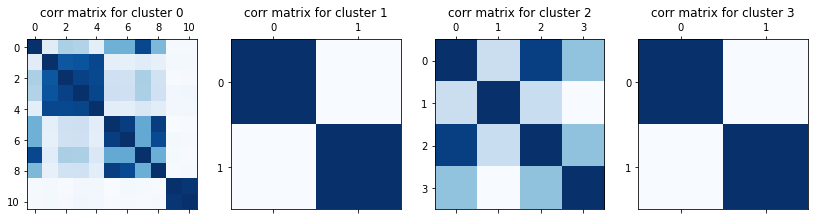

In [18]:
fig, axs = plt.subplots(1, k)
fig.set_size_inches(14, 6)
highly_corrs = []
for i in range(k):
    cluster_label = i
    cluster = fit_data.iloc[np.where(model.row_labels_ == cluster_label)[0]].iloc[:, np.where(model.column_labels_ == cluster_label)[0]]

    axs[i].matshow(cluster, cmap=plt.cm.Blues)
    axs[i].set_title("corr matrix for cluster {}".format(i))

    highly_corrs.append(list(cluster.columns))
    
plt.show()

In [19]:
highly_corrs = [['v190', 'v191', 'v121', 'v113', 'v119', 'v122', 'v124', 'v125', 'v129', 'v153', 'v120', 'v123', 'v161', 'v116'],
['v602', 'v605'],
['v106', 'v149', 'v133'],
['v135', 'v139', 'v140'],
['v364', 'v313', 'v361'],
['v201', 'v218', 'v219', 'v220', 'v224'],
['v613', 'v628', 'v627', 'v629'], ['v501', 'v502']]

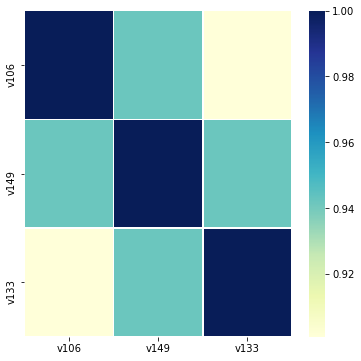

In [20]:
import matplotlib.pylab as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(X[highly_corrs[2]].corr().abs(), linewidth=0.5, cmap="YlGnBu", ax=ax)
plt.show()

In [21]:
X_pca = X.copy()
import sklearn
for i in range(len(highly_corrs)):
    print([(get_lbl(var), var) for var in highly_corrs[i]])
    if len(highly_corrs[i]) > 0:
        group_correlated_columns = highly_corrs[i]
        
        pca = sklearn.decomposition.PCA(n_components=1)
        pca_col = pca.fit_transform(X_pca[group_correlated_columns])
        print(pca.explained_variance_ratio_)
        print(pca_col.shape)

        X_pca.drop(columns=group_correlated_columns, inplace=True)
        X_pca = X_pca.join(pd.Series(pca_col.flatten(), index=X_pca.index, name='pca_' + str(i)))

[('Wealth index combined', 'v190'), ('Wealth index factor score combined (5 decimals)', 'v191'), ('Household has: television', 'v121'), ('Source of drinking water', 'v113'), ('Household has: electricity', 'v119'), ('Household has: refrigerator', 'v122'), ('Household has: motorcycle/scooter', 'v124'), ('Household has: car/truck', 'v125'), ('Main roof material', 'v129'), ('Household has: telephone (land-line)', 'v153'), ('Household has: radio', 'v120'), ('Household has: bicycle', 'v123'), ('Type of cooking fuel', 'v161'), ('Type of toilet facility', 'v116')]
[0.99999989]
(5649, 1)
[('Fertility preference', 'v602'), ('Desire for more children', 'v605')]
[0.99013824]
(5649, 1)
[('Highest educational level', 'v106'), ('Educational attainment', 'v149'), ('Education in single years', 'v133')]
[0.98080627]
(5649, 1)
[('Usual resident or visitor', 'v135'), ('De jure region of residence', 'v139'), ('De jure type of place of residence', 'v140')]
[0.99857718]
(5649, 1)
[('Contraceptive use and int

In [22]:
X_pca = X_pca.rename(columns={'pca_0': 'Wealth_Assets_index', 'pca_1': 'FertilityPref_index', 
                              'pca_2': 'Education_index', 'pca_3': 'Residence_index', 'pca_4': 'ContraceptiveUse_index', 
                              'pca_5': 'BirthCount_index', 'pca_6': 'IdealNumber_index', 'pca_7': 'MaritalStatus_index'})

In [23]:
X_pca.head()

,v101,v102,v115,v127,v128,v130,v131,v136,v137,v138,...,v623,v624,Wealth_Assets_index,FertilityPref_index,Education_index,Residence_index,ContraceptiveUse_index,BirthCount_index,IdealNumber_index,MaritalStatus_index
0,9,1,20.0,34.0,27.0,2.0,6.0,4,1,1,...,0.0,3.0,60925.521745,-1.211140,1.649088,2.160515,-0.492965,-2.474460,-2.899140,3.813326
1,9,1,2.0,34.0,27.0,2.0,6.0,1,0,1,...,0.0,3.0,46638.521736,-1.211140,-1.992649,2.160515,0.842706,-4.701307,-3.886196,3.813326
2,9,1,10.0,34.0,27.0,2.0,6.0,5,2,1,...,0.0,3.0,57516.520925,-2.054752,3.839274,2.160515,-0.492965,-2.474460,-2.899140,-0.286842
3,9,1,996.0,34.0,27.0,2.0,6.0,3,1,1,...,3.0,3.0,21828.521860,-2.054752,3.839274,2.160515,-0.492965,-2.752539,-3.886196,-0.286842
4,9,1,996.0,34.0,27.0,2.0,6.0,3,0,3,...,0.0,4.0,5151.521874,1.549990,-0.720019,2.160515,-0.492965,-0.247613,-2.891081,0.652356


In [24]:
X_pca['outcome'] = data['outcome']
X_pca['treatment'] = data['treatment']

In [25]:
X_pca.to_csv('../data/fp_pca.csv', index=False)

In [26]:
data = pd.read_csv('../data/fp_pca.csv')
X_df, a, y = get_data(data, data.columns[:-2])

In [28]:
c = X_pca.corr().abs()
c = c * np.tri(c.shape[0], c.shape[1], -1)
c = c.transpose()

thresholds = [.80]
corr_cols_len = []
for t in thresholds:
    corr_cols = [col for col in c.columns if any(c[col] > t) ]
    print(corr_cols)
    corr_cols_len.append(len(corr_cols))

[]


Text(0, 0.5, 'number of variables above threshold')

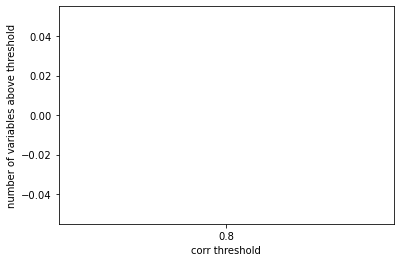

In [29]:
thresholds = [str(x) for x in thresholds]
plt.bar(thresholds, corr_cols_len)
plt.xlabel('corr threshold')
plt.ylabel('number of variables above threshold')

<AxesSubplot:>

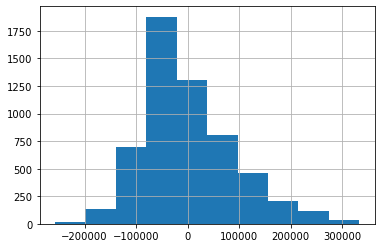

In [30]:
X_pca['Wealth_Assets_index'].hist()

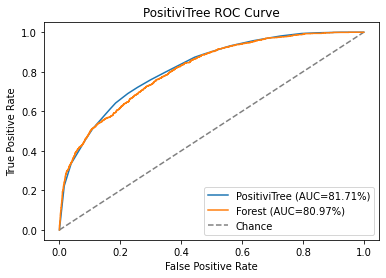

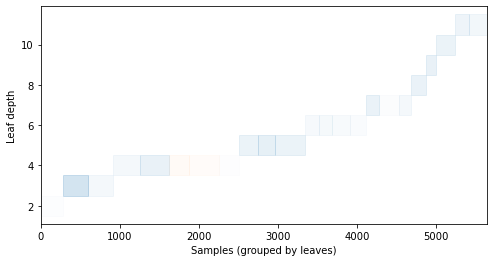

End.


In [31]:
ptree = PositiviTree(X_df, a,
                     violation_cutoff=0.1, consistency_cutoff=0.6,
                     n_consistency_tests=200, relative_violations=False,
                     # search_kws={"n_iter": 200},
                     dtc_kws={"criterion": "entropy"},
                     rfc_kws={"max_features": "auto"}
                     )

flagged_leaves = ptree._flag_out_leaves()
violating_samples = ptree._get_violating_samples_mask()
counts = ptree._count_violating_samples_in_forest(normalize=True)
tree_json_full = ptree.export_tree()
scores = ptree.evaluate_fit(plot_roc=True)

ax = visualize_leaves_static(ptree)
visualization_data = visualize_leaves_interactive(ptree, output_path='results/positivitree_viz_full.html')

print("End.")

In [32]:
print(len(X_df[violating_samples])/len(X_df))

leaves = ptree.export_leaves(extract_rules_kws={"clause_joiner": None})
violating_leaves = [leaf for leaf in leaves if leaf['is_violating']]

q_set = set()
for leaf in violating_leaves:
    for q in leaf['query']:
        print(q)
        q_set.add(q.feature_name)
    print('\n')

print(len(q_set))
print(q_set)

0.11683483802442911
(v235<=0.5)
(v513_2<=0.5)
(v137<=0.5)


(v235<=0.5)
(v513_2<=0.5)
(v137>0.5)
(v159<=0.5)


4
{'v137', 'v513_2', 'v159', 'v235'}


In [33]:
get_lbl('v159')

'Frequency of watching television'

In [7]:
# "Index last child prior to maternity-health (calendar)" == "No prior child"
# "Cohabitation duration (grouped)" == "Never married"
# "Number of children 5 and under in household (de jure)" == 0
# "Frequency of watching television" == "Not at all"

In [34]:
import json
with open('results/overall_full.json', 'w') as fp:
    fp.write(str(tree_json_full))

In [35]:
ax.get_figure().savefig('results/positivitree_overall.pdf')

In [36]:
X_df_ = X_df[X_df['v312_3'] == 0]
y_ = y[X_df['v312_3'] == 0]
a_ = a[X_df['v312_3'] == 0]

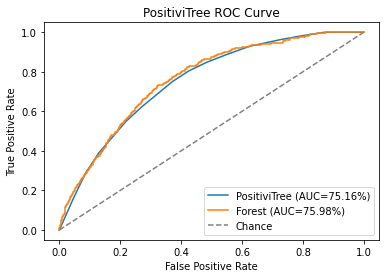

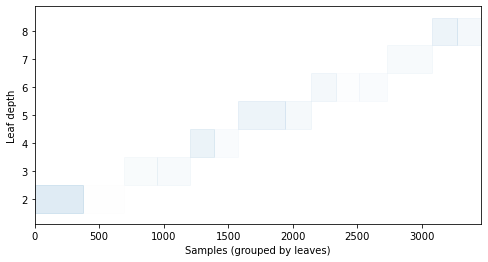

End.


In [37]:
ptree = PositiviTree(X_df_, a_,
                     violation_cutoff=0.1, consistency_cutoff=0.6,
                     n_consistency_tests=200, relative_violations=False,
                     # search_kws={"n_iter": 200},
                     dtc_kws={"criterion": "entropy"},
                     rfc_kws={"max_features": "auto"}
                     )

flagged_leaves = ptree._flag_out_leaves()
violating_samples_0 = ptree._get_violating_samples_mask()
counts = ptree._count_violating_samples_in_forest(normalize=True)
tree_json_0 = ptree.export_tree()
scores = ptree.evaluate_fit(plot_roc=True)

ax = visualize_leaves_static(ptree)
visualization_data = visualize_leaves_interactive(ptree, output_path='results/positivitree_viz_0.html')

print("End.")

In [38]:
print(len(X_df_[violating_samples_0])/len(X_df_))

leaves = ptree.export_leaves(extract_rules_kws={"clause_joiner": None})
violating_leaves = [leaf for leaf in leaves if leaf['is_violating']]

q_set = set()
for leaf in violating_leaves:
    for q in leaf['query']:
        print(q)
        q_set.add(q.feature_name)
    print('\n')
    
print(len(q_set))
print(q_set)

0.10850694444444445
(v235<=0.5)
(MaritalStatus_index<=-0.9281291514635086)


2
{'MaritalStatus_index', 'v235'}


In [ ]:
# "Index last child prior to maternity-health (calendar)" == "No prior child"
# "Current marital status" == "Never in union"
# "Cohabitation duration (grouped)" > "Never married"  -> Basically Married for some length of time
# "Time since last menstrual period" <= Xweeks ago
# "Current marital status" > "Never in union" -> Basically Married


In [39]:
import json
with open('results/strata0_full.json', 'w') as fp:
    fp.write(str(tree_json_0))

In [40]:
ax.get_figure().savefig('results/positivitree_curr_0.pdf')

In [41]:
X_df_ = X_df[X_df['v312_3'] == 1]
y_ = y[X_df['v312_3'] == 1]
a_ = a[X_df['v312_3'] == 1]

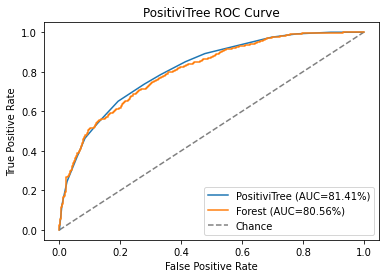

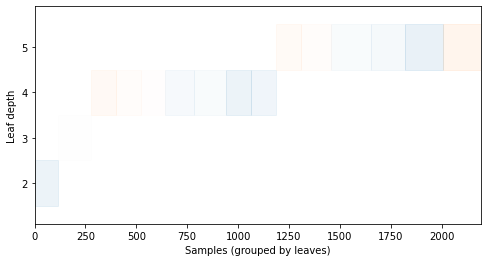

End.


In [42]:
ptree = PositiviTree(X_df_, a_,
                     violation_cutoff=0.1, consistency_cutoff=0.6,
                     n_consistency_tests=200, relative_violations=False,
                     # search_kws={"n_iter": 200},
                     dtc_kws={"criterion": "entropy"},
                     rfc_kws={"max_features": "auto"}
                     )

flagged_leaves = ptree._flag_out_leaves()
violating_samples_1 = ptree._get_violating_samples_mask()
counts = ptree._count_violating_samples_in_forest(normalize=True)
tree_json_1 = ptree.export_tree()
scores = ptree.evaluate_fit(plot_roc=True)

ax = visualize_leaves_static(ptree)
visualization_data = visualize_leaves_interactive(ptree, output_path='results/positivitree_viz_1.html')

print("End.")

In [43]:
print(len(X_df_[violating_samples_1])/len(X_df_))

leaves = ptree.export_leaves(extract_rules_kws={"clause_joiner": None})
violating_leaves = [leaf for leaf in leaves if leaf['is_violating']]

q_set = set()
for leaf in violating_leaves:
    for q in leaf['query']:
        print(q)
        q_set.add(q.feature_name)
    print("q_end")

print(len(q_set))
print(q_set)

0.06520747834017328
(v208>0.5)
(v235<=1.0)
(v513_1>0.5)
(v159<=0.5)
q_end
4
{'v235', 'v159', 'v208', 'v513_1'}


In [21]:
# "Births in last five years" > 0
# "Index last child prior to maternity-health (calendar)" <= 1
# "Cohabitation duration (grouped)"_5-9 == 0. -> is not (5-9)
# "Frequency of watching television" == "Not at all"
# "Wealth index factor score (5 decimals)" > -33375.5

# '(v208>0.5) AND (v235<=1.0) AND (v513_2<=0.5) AND (v159<=0.5) AND (v191>-33375.5)

In [44]:
import json
with open('results/strata1_full.json', 'w') as fp:
    fp.write(str(tree_json_1))

In [45]:
ax.get_figure().savefig('results/positivitree_curr_1.pdf')

In [24]:
from matplotlib_venn import venn2, venn3

In [154]:
violating_samples_ptree = X_df_[violating_samples_0]

In [155]:
len(violating_samples_ptree)

375

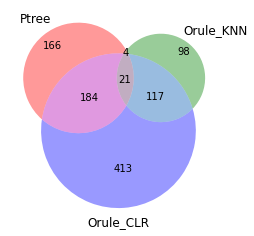

In [230]:
set1 = set(violating_samples_ptree.index)
set2 = set(knn_violating_index)
set3 = set(clr_violating_index)

fig, ax = plt.subplots()
venn3([set1, set2, set3], ('Ptree', 'Orule_KNN', 'Orule_CLR'), ax=ax)

In [208]:
ax.get_figure().savefig('results/venn_curr0_1.pdf')

In [124]:
overlap_indices = set(X_df_.index).difference(set(violating_samples_ptree.index))

In [ ]:
X_overlap = pd.merge(support, propensity, how='inner')
print(len(X_overlap) / len(X_df))

In [126]:
1 - len(overlap_indices)/len(X_df_)

0.10850694444444442

In [119]:
y = y_.loc[overlap_indices]
a = a_.loc[overlap_indices]
X = X_df_.loc[overlap_indices]

In [120]:
X.shape

(3081, 256)

In [46]:
from causallib.estimation import IPW
from causallib.evaluation import PropensityEvaluator

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import average_precision_score, roc_auc_score

from sklearn.metrics import make_scorer
from causallib.utils.stat_utils import robust_lookup

In [47]:
strartify_by = (a*2) + y
X_train, X_test, a_train, a_test, y_train, y_test = train_test_split(
    X_df, a, y, 
    train_size=0.7,
    test_size=0.3,
    shuffle=True, 
    random_state=1, 
    stratify=strartify_by
)

print(X_test.shape)

(1695, 175)


In [48]:
pd.concat({
    "entire": pd.crosstab(a, y, normalize="all"),
    "train": pd.crosstab(a_train, y_train, normalize="all"),
    "test": pd.crosstab(a_test, y_test, normalize="all")
    },
    axis="columns"
)

entire               train                test          
outcome           0         1         0         1         0         1
treatment                                                            
0          0.702779  0.047973  0.702833  0.048053  0.702655  0.047788
1          0.227651  0.021597  0.227618  0.021497  0.227729  0.021829

In [49]:
def weighted_auc_scorer(clf, X, a_true):
    #greater is better
    
    a_proba = pd.DataFrame(clf.predict_proba(X))
    weight_matrix = a_proba.rdiv(1.0)
    
    a_true = a_true.reset_index(drop=True)
    prevalence = a_true.value_counts(normalize=True, sort=False)
    prevalence_per_subject = a_true.replace(prevalence)  

    weight_matrix = weight_matrix.multiply(prevalence_per_subject, axis="index")
    weights = robust_lookup(weight_matrix, a_true)
    
    score =  roc_auc_score(a_true, clf.predict_proba(X)[:, 1], sample_weight=weights)
    return 1 - abs(score - 0.5)

In [65]:
base_estimator = LogisticRegression(
    penalty="l2", 
    max_iter=2000,
    class_weight="balanced",
    random_state=2,
    solver='lbfgs'
)
learner = CalibratedClassifierCV(base_estimator=base_estimator, cv=3, method='sigmoid')
param_grid = {'base_estimator__C': np.logspace(-5, 0, 20)}
search = GridSearchCV(learner, param_grid, cv=5, scoring=weighted_auc_scorer)

ipw = IPW(make_pipeline(StandardScaler(), search), use_stabilized=True)
ipw.fit(X_train, a_train)

IPW(truncate_eps=None, use_stabilized=True,
    learner=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=CalibratedClassifierCV(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                                 max_iter=2000,
                                                                                                 random_state=2),
                                                               cv=3),
                              param_grid={'base_estimator__C': array([1.00000000e-05, 1.83298071e-05, 3.35981829e-05, 6.15848211e-05,
       1.12883789e-04, 2.06913808e-04, 3.79269019e-04, 6.95192796e-04,
       1.27427499e-03, 2.33572147e-03, 4.28133240e-03, 7.84759970e-03,
       1.43844989e-02, 2.63665090e-02, 4.83293024e-02, 8.85866790e-02,
       1.62377674e-01, 2.97635144e-01, 5.45559478e-01, 1

In [66]:
ipw = IPW(make_pipeline(StandardScaler(), ipw.learner.steps[1][1].best_estimator_), use_stabilized=True)
ipw.fit(X_train, a_train)

IPW(truncate_eps=None, use_stabilized=True,
    learner=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('calibratedclassifiercv',
                 CalibratedClassifierCV(base_estimator=LogisticRegression(C=1e-05,
                                                                          class_weight='balanced',
                                                                          max_iter=2000,
                                                                          random_state=2),
                                        cv=3))]))

In [70]:
a_train_pred = ipw.learner.predict_proba(X_train)[:,1]
roc_auc_score(a_train, a_train_pred, sample_weight=None)

0.7467796673921555

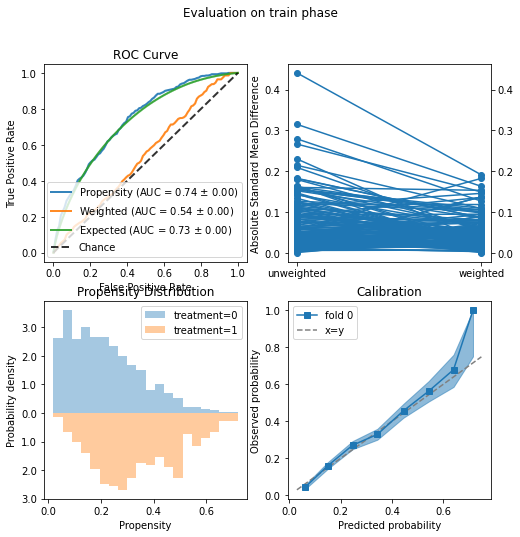

In [68]:
plots=["roc_curve", "covariate_balance_slope", "weight_distribution", "calibration"]

evaluator = PropensityEvaluator(ipw)
evaluations = evaluator.evaluate_simple(X_test.astype(float), a_test, y_test, plots=plots)

fig = evaluations.plots['covariate_balance_slope'].get_figure().set_size_inches(8, 8) 

In [54]:
evaluations.scores.covariate_balance.sort_values(by='weighted', ascending=False).head()

abs_smd,weighted,unweighted
covariate,,
v312_3,0.190881,0.440916
v513_2,0.182330,0.058055
v513_1,0.162654,0.314800
v312_6,0.152970,0.160109
v208,0.148977,0.266416


In [55]:
from sklearn.utils import resample
n_bootstrap = 2000
import warnings
warnings.filterwarnings("ignore")

effects = []
for i in range(n_bootstrap):
    X_r, a_r, y_r = resample(X_test, a_test, y_test, n_samples=None, random_state=i)
    
    X_r = X_r.reset_index(drop=True)
    a_r = a_r.reset_index(drop=True)
    y_r = y_r.reset_index(drop=True)
    
    potential_outcomes = ipw.estimate_population_outcome(X_r, a_r, y_r)
    causal_effect = ipw.estimate_effect(potential_outcomes[1], potential_outcomes[0])
    effects.append(causal_effect)

median = np.median(effects)
lower = np.percentile(effects, 2.5)
upper = np.percentile(effects, 97.5)
print(median, lower, upper)

0.05525265528903079 0.011736008004676512 0.10266574773800775


In [56]:
placebo_effects = []
p_a = a_test.mean()
for i in range(1000):
    
    X_boots, a_boots, y_boots = resample(X_test, a_test, y_test, n_samples=None, random_state=i)
    random_a = np.random.binomial(1, p_a, size=X_boots.shape[0])
    
    random_a = pd.Series(random_a)
    X_boots = X_boots.reset_index(drop=True)
    y_boots = y_boots.reset_index(drop=True)
    
    ipw.fit(X_boots, random_a)
    potential_outcomes = ipw.estimate_population_outcome(X_boots, random_a, y_boots)
    placebo_effects.append(ipw.estimate_effect(potential_outcomes[1], potential_outcomes[0]))
    
np.mean(placebo_effects) # +/- 0

0.00011557211400451425

In [57]:
evaluations.plots['weight_distribution'].get_figure().savefig('results/curr0.pdf')

In [224]:
# X_df, a, y = get_data()

X_df_, a_, y_ = get_data()

X_df = X_df_[X_df_['v312_3'] == 0]
y = y_[X_df_['v312_3'] == 0]
a = a_[X_df_['v312_3'] == 0]

X_df.shape, y.shape, a.shape

((3456, 256), (3456,), (3456,))

In [227]:
print(len(X_df)/len(X_df_))
print(1 - (len(X_df)/len(X_df_)))

0.6117896972915561
0.3882103027084439


In [229]:
# # support = X_df[(~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & X_df["v513_2"].astype(bool) & ~X_df["v513_3"].astype(bool) & ~X_df["v602_4"].astype(bool))| (X_df["v129_97"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v202"] <= 2.500) & (X_df["v208"] <= 1.500) & ~X_df["v602_4"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v235"] > 2.500) & ~X_df["v513_2"].astype(bool) & ~X_df["v602_4"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v235"] <= 2.500) & ~X_df["v312_3"].astype(bool) & ~X_df["v513_2"].astype(bool) & X_df["v513_3"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v235"] <= 2.500) & (X_df["v235"] > 0.500) & X_df["v312_3"].astype(bool) & ~X_df["v602_4"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v208"] > 0.500) & (X_df["v235"] > 2.500) & ~X_df["v602_4"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v202"] <= 2.500) & (X_df["v208"] <= 1.500) & (X_df["v235"] <= 2.500) & (X_df["v235"] > 1.500) & ~X_df["v312_3"].astype(bool) & ~X_df["v513_3"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v235"] <= 0.500) & ~X_df["v513_3"].astype(bool) & ~X_df["v602_4"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v202"] <= 2.500) & (X_df["v208"] <= 1.500) & (X_df["v235"] <= 1.000) & (X_df["v235"] > 0.500) & ~X_df["v312_3"].astype(bool) & ~X_df["v513_3"].astype(bool) & ~X_df["v602_4"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v202"] > 2.500) & (X_df["v208"] <= 1.500) & (X_df["v235"] <= 2.500) & ~X_df["v312_3"].astype(bool) & ~X_df["v513_2"].astype(bool) & ~X_df["v513_3"].astype(bool) & ~X_df["v602_4"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v202"] <= 2.500) & (X_df["v208"] <= 0.500) & ~X_df["v513_2"].astype(bool) & ~X_df["v513_3"].astype(bool) & ~X_df["v602_4"].astype(bool))]


# # clr_propensity = X_df[((X_df["v133"] > 12.500) & (X_df["v137"] <= 1.500) & (X_df["v152"] <= 57.500) & (X_df["v191"] <= 95263.500) & (X_df["v235"] > 0.500))| ((X_df["v133"] <= 12.500) & (X_df["v152"] <= 45.500) & (X_df["v191"] <= 95263.500) & (X_df["v235"] <= 0.500) & X_df["v312_3"].astype(bool))| ((X_df["v133"] <= 12.500) & (X_df["v137"] <= 1.500) & (X_df["v152"] <= 57.500) & (X_df["v191"] > 95263.500) & (X_df["v235"] > 0.500))| ((X_df["v133"] <= 12.500) & (X_df["v137"] <= 1.500) & (X_df["v152"] <= 45.500) & (X_df["v167"] <= 2.500) & (X_df["v191"] <= 95263.500) & (X_df["v235"] <= 0.500) & ~X_df["v312_3"].astype(bool))| ((X_df["v133"] <= 12.500) & (X_df["v137"] > 1.500) & (X_df["v152"] <= 45.500) & (X_df["v191"] <= 95263.500) & (X_df["v235"] > 0.500))| ((X_df["v133"] <= 12.500) & (X_df["v137"] > 1.500) & (X_df["v152"] <= 75.500) & (X_df["v152"] > 57.500) & (X_df["v235"] > 0.500))| ((X_df["v133"] <= 12.500) & (X_df["v137"] <= 1.500) & (X_df["v191"] <= 131083.500) & (X_df["v235"] > 0.500))| ((X_df["v133"] <= 12.500) & (X_df["v191"] > 131083.500) & X_df["v312_3"].astype(bool))| ((X_df["v133"] <= 12.500) & (X_df["v137"] > 1.500) & (X_df["v152"] <= 75.500) & (X_df["v167"] <= 2.500) & (X_df["v191"] <= 166983.000) & (X_df["v191"] > 95263.500) & (X_df["v235"] > 0.500))| ((X_df["v152"] <= 57.500) & (X_df["v152"] > 45.500) & (X_df["v191"] <= 131083.500) & (X_df["v235"] > 0.500))]

# # knn_propensity = X_df[((X_df["v191"] <= 290545.000) & (X_df["v191"] > -188796.000))]


# support = X_df[(X_df["v129_97"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v202"] <= 2.500) & (X_df["v208"] <= 1.500) & ~X_df["v602_4"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & ~X_df["v513_3"].astype(bool) & ~X_df["v602_4"].astype(bool))| (~X_df["v129_97"].astype(bool) & ~X_df["v140_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v235"] > 0.500) & ~X_df["v513_2"].astype(bool) & X_df["v513_3"].astype(bool))]

# clr_propensity = X_df[((X_df["v152"] <= 49.500) & (X_df["v191"] <= 166983.000) & (X_df["v226"] <= 996.000) & X_df["v312_3"].astype(bool))| ((X_df["v133"] <= 12.500) & (X_df["v137"] > 1.500) & (X_df["v152"] <= 75.500) & (X_df["v191"] <= 166983.000) & (X_df["v226"] <= 996.000) & (X_df["v235"] > 0.500) & ~X_df["v312_3"].astype(bool))| ((X_df["v133"] <= 12.500) & (X_df["v137"] <= 1.500) & (X_df["v152"] <= 57.500) & (X_df["v191"] > 131083.500) & (X_df["v205"] <= 0.500) & (X_df["v226"] <= 996.000) & (X_df["v235"] > 0.500))| ((X_df["v133"] <= 12.500) & (X_df["v137"] <= 1.500) & (X_df["v152"] <= 49.500) & (X_df["v205"] > 0.500) & (X_df["v226"] <= 996.000))| ((X_df["v133"] <= 12.500) & (X_df["v137"] <= 1.500) & (X_df["v191"] <= 131083.500) & (X_df["v226"] <= 996.000) & (X_df["v235"] > 0.500))| ((X_df["v133"] <= 12.500) & (X_df["v137"] <= 1.500) & (X_df["v152"] <= 49.500) & (X_df["v167"] <= 2.500) & (X_df["v191"] <= 131083.500) & (X_df["v226"] <= 996.000) & (X_df["v235"] <= 0.500) & ~X_df["v312_3"].astype(bool))| ((X_df["v137"] <= 1.500) & (X_df["v152"] <= 57.500) & (X_df["v191"] <= 131083.500) & (X_df["v226"] <= 996.000) & (X_df["v235"] > 0.500) & ~X_df["v312_3"].astype(bool))| ((X_df["v133"] <= 12.500) & (X_df["v137"] > 1.500) & (X_df["v152"] <= 75.500) & (X_df["v191"] <= 166983.000) & (X_df["v235"] > 0.500) & X_df["v312_3"].astype(bool))]


# knn_propensity = X_df[((X_df["v191"] <= 290545.000) & (X_df["v191"] > -188796.000))]


############

# support = X_df[((X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v208"] > 0.500) & (X_df["v235"] <= 1.000) & (X_df["v238"] > 0.500) & X_df["v513_2"].astype(bool) & (X_df["v531"] > 13.500))| (X_df["v150_2"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v208"] > 0.500) & (X_df["v235"] <= 1.000) & (X_df["v238"] > 0.500) & X_df["v513_2"].astype(bool) & (X_df["v531"] > 13.500))| ((X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v208"] > 0.500) & (X_df["v235"] <= 1.000) & X_df["v513_2"].astype(bool) & (X_df["v531"] > 13.500))| ((X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v235"] > 1.500) & (X_df["v238"] <= 0.500) & (X_df["v531"] > 13.500))| (~X_df["v101_5"].astype(bool) & X_df["v150_2"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v208"] > 1.500) & ~X_df["v513_2"].astype(bool) & (X_df["v531"] > 13.500))| (~X_df["v101_5"].astype(bool) & (X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] <= 0.500) & (X_df["v238"] <= 0.500) & (X_df["v531"] > 13.500))| ((X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] > 0.500) & (X_df["v235"] <= 1.000) & (X_df["v238"] > 0.500) & ~X_df["v513_2"].astype(bool) & (X_df["v531"] <= 13.500))| (~X_df["v101_5"].astype(bool) & (X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] > 0.500) & (X_df["v235"] > 1.500) & (X_df["v238"] > 0.500) & X_df["v513_2"].astype(bool))| (~X_df["v101_5"].astype(bool) & (X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v208"] > 0.500) & (X_df["v235"] > 1.500) & (X_df["v238"] > 0.500) & ~X_df["v513_2"].astype(bool))| (~X_df["v101_5"].astype(bool) & ~X_df["v150_2"].astype(bool) & (X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] > 1.500) & (X_df["v238"] > 0.500) & ~X_df["v513_2"].astype(bool) & (X_df["v531"] > 13.500))| ((X_df["v201"] > 0.500) & (X_df["v238"] <= 0.500) & (X_df["v531"] <= 13.500))| (~X_df["v101_5"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v208"] > 0.500) & (X_df["v235"] > 1.500) & (X_df["v238"] <= 0.500) & (X_df["v531"] > 13.500))| (X_df["v101_5"].astype(bool) & (X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] > 0.500) & (X_df["v235"] > 1.500) & (X_df["v238"] > 0.500) & ~X_df["v513_2"].astype(bool))| (X_df["v101_5"].astype(bool) & (X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] > 0.500) & (X_df["v235"] > 1.500) & (X_df["v238"] > 0.500) & X_df["v513_2"].astype(bool) & (X_df["v531"] > 13.500))| ((X_df["v191"] > 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v238"] <= 0.500) & (X_df["v531"] > 13.500))| ((X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v235"] <= 1.000) & (X_df["v238"] <= 0.500) & (X_df["v531"] > 13.500))| (X_df["v101_5"].astype(bool) & (X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v238"] <= 0.500) & (X_df["v531"] > 13.500))]


# clr_propensity = X_df[((X_df["v137"] <= 2.500) & (X_df["v208"] <= 1.500))| ((X_df["v115"] <= 997.500) & (X_df["v137"] <= 2.500) & (X_df["v208"] <= 2.500) & (X_df["v525"] <= 15.500))| (X_df["v120_1"].astype(bool) & (X_df["v137"] <= 2.500) & (X_df["v202"] > 1.500))]

# knn_propensity = X_df[((X_df["v208"] <= 2.500))]


# support = X_df[((X_df["v201"] > 0.500) & (X_df["v208"] > 0.500) & (X_df["v235"] <= 1.000) & (X_df["v238"] > 0.500) & X_df["v513_2"].astype(bool) & (X_df["v531"] > 13.500))| (~X_df["v101_5"].astype(bool) & X_df["v150_2"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v208"] > 1.500) & ~X_df["v513_2"].astype(bool) & (X_df["v531"] > 13.500))| ((X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] > 0.500) & ~X_df["v513_2"].astype(bool) & (X_df["v531"] <= 13.500))| ((X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v238"] <= 0.500))| (~X_df["v101_5"].astype(bool) & (X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] > 0.500) & (X_df["v235"] > 1.500) & (X_df["v238"] > 0.500) & X_df["v513_2"].astype(bool))| (~X_df["v101_5"].astype(bool) & (X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] <= 1.500) & (X_df["v208"] > 0.500) & (X_df["v235"] > 1.500) & (X_df["v238"] > 0.500) & ~X_df["v513_2"].astype(bool) & (X_df["v531"] > 13.500))| (X_df["v101_5"].astype(bool) & (X_df["v191"] <= 156046.000) & (X_df["v201"] > 0.500) & (X_df["v208"] > 0.500) & (X_df["v235"] > 1.500) & (X_df["v238"] > 0.500) & (X_df["v531"] > 13.500))| (~X_df["v101_5"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v208"] > 1.500) & ~X_df["v513_2"].astype(bool) & (X_df["v531"] > 13.500))]

# clr_propensity = X_df[((X_df["v137"] <= 2.500) & (X_df["v226"] <= 503.500) & (X_df["v235"] > 1.500))| ((X_df["v137"] <= 2.500) & (X_df["v208"] <= 1.500))]

# knn_propensity = X_df[((X_df["v208"] <= 2.500))]


############

# support = X_df[(~X_df["v119_7"].astype(bool) & ~X_df["v122_7"].astype(bool) & ~X_df["v128_22"].astype(bool) & (X_df["v149"] > 2.500) & (X_df["v235"] > 0.500) & ~X_df["v513_2"].astype(bool) & (X_df["v525"] > 9.500) & (X_df["v531"] > 9.500) & ~X_df["v602_4"].astype(bool) & (X_df["v613"] > 2.500))| (~X_df["v119_7"].astype(bool) & ~X_df["v122_7"].astype(bool) & ~X_df["v128_22"].astype(bool) & X_df["v513_2"].astype(bool) & ~X_df["v513_3"].astype(bool) & (X_df["v525"] > 9.500) & (X_df["v531"] > 9.500) & ~X_df["v602_4"].astype(bool))| (~X_df["v101_7"].astype(bool) & X_df["v119_7"].astype(bool) & ~X_df["v128_22"].astype(bool) & (X_df["v202"] <= 2.500) & (X_df["v525"] > 9.500) & (X_df["v531"] > 9.500) & ~X_df["v602_4"].astype(bool))| (~X_df["v119_7"].astype(bool) & ~X_df["v122_7"].astype(bool) & ~X_df["v128_22"].astype(bool) & (X_df["v149"] <= 2.500) & ~X_df["v513_2"].astype(bool) & (X_df["v525"] > 9.500) & (X_df["v531"] > 9.500) & ~X_df["v602_4"].astype(bool) & (X_df["v613"] > 2.500))| (~X_df["v101_7"].astype(bool) & ~X_df["v119_7"].astype(bool) & ~X_df["v122_7"].astype(bool) & ~X_df["v128_22"].astype(bool) & (X_df["v202"] <= 2.500) & (X_df["v235"] <= 2.500) & (X_df["v525"] > 9.500) & (X_df["v531"] > 9.500) & X_df["v602_4"].astype(bool) & (X_df["v613"] > 2.500))| (~X_df["v101_7"].astype(bool) & ~X_df["v119_7"].astype(bool) & ~X_df["v122_7"].astype(bool) & X_df["v128_22"].astype(bool) & (X_df["v235"] <= 2.500) & (X_df["v525"] > 9.500) & (X_df["v531"] > 9.500) & ~X_df["v602_4"].astype(bool))| (~X_df["v119_7"].astype(bool) & ~X_df["v122_7"].astype(bool) & ~X_df["v513_2"].astype(bool) & (X_df["v613"] <= 2.500))]


# clr_propensity = X_df[((X_df["v149"] > 3.500) & (X_df["v152"] <= 55.500) & (X_df["v191"] <= 172282.000) & (X_df["v226"] <= 545.000) & ~X_df["v513_0"].astype(bool))| ((X_df["v133"] <= 13.500) & (X_df["v152"] <= 64.500) & (X_df["v191"] <= 268974.000) & (X_df["v226"] <= 533.500) & (X_df["v235"] > 0.500) & ~X_df["v501_0"].astype(bool) & ~X_df["v513_0"].astype(bool) & (X_df["v613"] <= 3.500))| ((X_df["v136"] > 6.500) & (X_df["v149"] <= 2.500) & (X_df["v152"] <= 64.500))| ((X_df["v149"] <= 3.500) & (X_df["v152"] <= 55.500) & (X_df["v191"] <= 268974.000) & (X_df["v226"] <= 545.000))]

# knn_propensity = X_df[((X_df["v191"] <= 123525.000) & (X_df["v191"] > -152637.000) & (X_df["v227"] <= 7.000))| ((X_df["v191"] <= 257663.500) & (X_df["v191"] > 132820.000))]


support = X_df[(~X_df["v119_7"].astype(bool) & ~X_df["v122_7"].astype(bool) & (X_df["v525"] > 9.500) & (X_df["v531"] > 9.500))| (~X_df["v101_7"].astype(bool) & X_df["v119_7"].astype(bool) & X_df["v122_7"].astype(bool) & ~X_df["v128_22"].astype(bool) & (X_df["v202"] <= 2.500) & ~X_df["v513_3"].astype(bool) & (X_df["v525"] > 9.500) & (X_df["v531"] > 9.500) & ~X_df["v602_4"].astype(bool))]


clr_propensity = X_df[((X_df["v106"] <= 2.500) & (X_df["v106"] > 1.500) & (X_df["v149"] > 2.500) & ~X_df["v150_3"].astype(bool) & (X_df["v152"] <= 55.500) & (X_df["v191"] <= 169349.500) & (X_df["v215"] <= 994.500) & (X_df["v226"] <= 545.000) & ~X_df["v602_3"].astype(bool))| ((X_df["v133"] <= 10.500) & ~X_df["v151_2"].astype(bool) & (X_df["v152"] <= 64.500) & (X_df["v226"] <= 545.000))| ((X_df["v106"] <= 2.500) & (X_df["v152"] <= 55.500) & (X_df["v226"] <= 545.000) & X_df["v602_3"].astype(bool))| ((X_df["v149"] <= 2.500) & (X_df["v152"] <= 55.500) & (X_df["v191"] <= 169349.500) & (X_df["v226"] <= 545.000))| ((X_df["v106"] > 2.500) & ~X_df["v150_3"].astype(bool) & (X_df["v152"] <= 55.500) & (X_df["v191"] <= 169349.500) & (X_df["v226"] <= 545.000))]

knn_propensity = X_df[((X_df["v191"] <= 123525.000) & (X_df["v191"] > -152637.000) & (X_df["v227"] <= 7.000))| ((X_df["v191"] <= 257663.500) & (X_df["v191"] > 132820.000))]


propensity = knn_propensity

intersection = set(list(support.index)).intersection(set(list(propensity.index)))
a_overlap = a.loc[list(intersection)].reset_index()
y_overlap = y.loc[list(intersection)].reset_index()

print(len(support)/len(X_df))
print(len(propensity)/len(X_df))

X_overlap = pd.merge(support, propensity, how='inner')
print(len(X_overlap) / len(X_df))

# clr_violating_index = list(set(X_df.index) - intersection)

knn_violating_index = list(set(X_df.index) - intersection)

0.9916087962962963
0.9383680555555556
0.9305555555555556


In [173]:
X = pd.DataFrame(X_overlap.values)
y = pd.Series(y_overlap['outcome'].values)
a = pd.Series(a_overlap['treatment'].values)

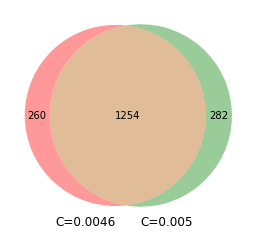

In [238]:
support = X_df[(X_df["v123_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v202"] <= 2.500) & (X_df["v208"] <= 1.500) & ~X_df["v602_4"].astype(bool))| (~X_df["v113_97"].astype(bool) & ~X_df["v123_7"].astype(bool) & (X_df["v201"] > 0.500) & ~X_df["v513_3"].astype(bool) & ~X_df["v602_4"].astype(bool))| (~X_df["v113_97"].astype(bool) & ~X_df["v123_7"].astype(bool) & (X_df["v201"] > 0.500) & (X_df["v235"] > 0.500) & ~X_df["v513_2"].astype(bool) & X_df["v513_3"].astype(bool))]

propensity = X_df[((X_df["v137"] <= 3.500) & (X_df["v149"] <= 2.500) & (X_df["v152"] <= 34.500) & (X_df["v191"] <= 99419.500) & (X_df["v226"] <= 996.000))| ((X_df["v152"] <= 64.500) & (X_df["v208"] <= 0.500) & ~X_df["v536_3"].astype(bool))| ((X_df["v133"] <= 13.000) & (X_df["v137"] <= 3.500) & (X_df["v152"] <= 68.500) & (X_df["v191"] <= 99419.500) & (X_df["v208"] <= 1.500) & (X_df["v226"] <= 996.000) & (X_df["v235"] > 0.500))| ((X_df["v133"] <= 12.500) & (X_df["v152"] <= 34.500) & (X_df["v226"] <= 996.000) & X_df["v312_3"].astype(bool))| ((X_df["v152"] <= 34.500) & (X_df["v191"] <= 99419.500) & (X_df["v208"] <= 1.500) & X_df["v312_3"].astype(bool))| ((X_df["v106"] <= 2.500) & (X_df["v133"] <= 13.000) & (X_df["v137"] <= 3.500) & (X_df["v149"] <= 2.500) & (X_df["v152"] <= 68.500) & (X_df["v152"] > 34.500) & (X_df["v191"] <= 99419.500) & (X_df["v226"] <= 996.000) & (X_df["v235"] > 0.500) & X_df["v536_3"].astype(bool))| ((X_df["v137"] <= 3.500) & (X_df["v235"] > 0.500) & X_df["v312_3"].astype(bool) & ~X_df["v536_3"].astype(bool))| ((X_df["v106"] <= 1.500) & (X_df["v133"] <= 13.000) & (X_df["v137"] <= 3.500) & (X_df["v149"] <= 2.500) & (X_df["v152"] <= 64.500) & (X_df["v191"] <= 99419.500) & (X_df["v208"] > 0.500) & (X_df["v226"] <= 996.000) & X_df["v312_3"].astype(bool) & ~X_df["v536_3"].astype(bool))| ((X_df["v152"] <= 34.500) & (X_df["v191"] <= 99419.500) & (X_df["v226"] <= 996.000) & (X_df["v235"] > 0.500) & ~X_df["v536_3"].astype(bool))| ((X_df["v133"] <= 12.500) & (X_df["v152"] <= 34.500) & (X_df["v208"] <= 0.500))| ((X_df["v152"] <= 68.500) & (X_df["v208"] <= 0.500) & X_df["v312_3"].astype(bool))| ((X_df["v106"] > 2.500) & (X_df["v133"] <= 13.000) & (X_df["v137"] <= 3.500) & (X_df["v152"] <= 64.500) & (X_df["v152"] > 34.500) & (X_df["v208"] > 0.500) & (X_df["v226"] <= 996.000) & (X_df["v235"] > 0.500) & ~X_df["v312_3"].astype(bool) & ~X_df["v536_3"].astype(bool))| ((X_df["v149"] <= 2.500) & (X_df["v152"] <= 68.500) & (X_df["v235"] > 0.500) & X_df["v312_3"].astype(bool))| ((X_df["v149"] <= 2.500) & (X_df["v152"] <= 34.500) & (X_df["v208"] <= 1.500) & (X_df["v226"] <= 996.000))| ((X_df["v149"] <= 2.500) & (X_df["v208"] <= 0.500) & ~X_df["v312_3"].astype(bool))| ((X_df["v106"] <= 2.500) & (X_df["v133"] <= 13.000) & (X_df["v137"] <= 3.500) & (X_df["v149"] <= 2.500) & (X_df["v152"] <= 64.500) & (X_df["v226"] <= 996.000) & (X_df["v235"] > 0.500) & ~X_df["v312_3"].astype(bool) & ~X_df["v536_3"].astype(bool))]


propensity2 = X_df[((X_df["v137"] <= 2.500) & (X_df["v149"] <= 3.500) & (X_df["v152"] <= 61.500) & (X_df["v191"] <= 176527.500) & (X_df["v235"] > 0.500))| ((X_df["v106"] > 0.500) & ~X_df["v129_33"].astype(bool) & (X_df["v133"] > 1.000) & (X_df["v137"] <= 2.500) & (X_df["v152"] <= 61.500) & (X_df["v191"] > 68857.000) & (X_df["v235"] > 0.500) & (X_df["v614"] <= 3.500) & X_df["v624_4"].astype(bool))| (~X_df["v129_33"].astype(bool) & (X_df["v133"] > 1.000) & (X_df["v137"] <= 2.500) & (X_df["v149"] <= 3.500) & (X_df["v152"] <= 36.500) & (X_df["v191"] <= 176527.500) & (X_df["v235"] <= 0.500) & ~X_df["v312_3"].astype(bool) & (X_df["v614"] <= 3.500))| (~X_df["v129_33"].astype(bool) & (X_df["v137"] <= 2.500) & (X_df["v149"] <= 3.500) & (X_df["v152"] <= 75.500) & (X_df["v152"] > 49.500) & (X_df["v191"] <= 68857.000) & (X_df["v235"] > 0.500) & ~X_df["v312_3"].astype(bool))| ((X_df["v152"] <= 75.500) & (X_df["v191"] <= 68857.000) & (X_df["v235"] > 0.500) & X_df["v312_3"].astype(bool))| ((X_df["v152"] <= 36.500) & (X_df["v235"] > 0.500) & X_df["v312_3"].astype(bool))| ((X_df["v133"] <= 1.000) & (X_df["v152"] <= 49.500) & X_df["v624_4"].astype(bool))| ((X_df["v137"] <= 2.500) & (X_df["v235"] > 0.500) & X_df["v312_3"].astype(bool) & (X_df["v614"] <= 3.500))| ((X_df["v106"] > 0.500) & ~X_df["v129_33"].astype(bool) & (X_df["v133"] > 1.000) & (X_df["v137"] <= 2.500) & (X_df["v149"] > 3.500) & (X_df["v152"] <= 61.500) & (X_df["v152"] > 36.500) & (X_df["v191"] <= 176527.500) & (X_df["v235"] > 0.500) & X_df["v624_4"].astype(bool))| (X_df["v129_33"].astype(bool) & (X_df["v235"] > 0.500) & ~X_df["v624_4"].astype(bool))| (~X_df["v129_33"].astype(bool) & (X_df["v152"] <= 49.500) & X_df["v312_3"].astype(bool) & (X_df["v614"] <= 3.500))| ((X_df["v106"] > 0.500) & ~X_df["v129_33"].astype(bool) & (X_df["v133"] > 1.000) & (X_df["v137"] <= 2.500) & (X_df["v149"] > 3.500) & (X_df["v152"] <= 49.500) & (X_df["v191"] <= 68857.000) & (X_df["v235"] > 0.500) & ~X_df["v312_3"].astype(bool))| ((X_df["v106"] > 0.500) & ~X_df["v129_33"].astype(bool) & (X_df["v133"] > 1.000) & (X_df["v137"] > 2.500) & (X_df["v149"] <= 3.500) & (X_df["v152"] <= 75.500) & (X_df["v191"] <= 176527.500) & (X_df["v235"] > 0.500) & ~X_df["v312_3"].astype(bool) & X_df["v624_4"].astype(bool))| (~X_df["v129_33"].astype(bool) & (X_df["v137"] <= 2.500) & (X_df["v149"] <= 3.500) & (X_df["v152"] <= 36.500) & X_df["v312_3"].astype(bool))]


intersection = set(list(support.index)).intersection(set(list(propensity.index)))
violating_index = list(set(X_df.index) - intersection)


intersection2 = set(list(support.index)).intersection(set(list(propensity2.index)))
violating_index2 = list(set(X_df.index) - intersection2)

from matplotlib_venn import venn2, venn3

set1 = set(violating_index)
set2 = set(violating_index2)

fig, ax = plt.subplots()
venn2([set1, set2], ('C=0.0046', 'C=0.005'), ax=ax)